<a href="https://colab.research.google.com/github/vss245/nma_code/blob/master/hcp_fmri_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro and theory
Dataset: HCP fMRI dataset, preprocessed and parcellated into 360 ROIs

Task: Observing shapes moving either randomly or appearing to interact "socially"
 
Question: how does the brain encode viewing social interaction?

ROIs: temporoparietal junction, superior temporal sulcus, medial prefrontal cortex, fusiform gyrus, occipital gyrus, amygdala, insula 

Model: 
- ROIs indicated above interact with each other throughout this process of observing social interaction
- We can measure this interaction via effective connectivity (e.g. Granger causality)
- Viewing social interaction will increase GC between the ROIs, whereas random motion will not (control: random network, such as lower visual areas) 

Approach:
- extract time series for every subject for these ROIs in both conditions
- calculate GC between them (multivariate GC? fit a VAR?)

Hypothesis: viewing social interaction increases connectivity between areas within the "social network" of the brain

Statistics: 
- due to the structure of the experiment, we obtain GC separately for each condition per run and average across runs
- after that, we have 1 GC value per condition per pairs of regions per subject (potentially we can subtract the two GC values and just look at the GC condition difference per pairs of regions per subject)
- group level stats: ANOVA 


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Parameters

In [3]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

# Loading functions

In [4]:
fname = "hcp_task.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/s4h8j/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [5]:
#@title Helper functions: get image index, load_timeseries, load_evs (provided)
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
    i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
  ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}''")
  return run_ids

def load_timeseries(subject, name, runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.
  
  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment 
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
      load_single_timeseries(subject, offset + run, remove_mean) for run in runs
  ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

def load_evs(subject, name, condition):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{condition}.txt"
    ev = dict(zip(["onset", "duration", "amplitude"], np.genfromtxt(ev_file).T))
    evs.append(ev)
  return evs

def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averaged across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

## Region info

In [292]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    myelin=regions[2].astype(np.float),
)

regionsdf = pd.DataFrame.from_dict(region_info)
# make a dictionary with all of the above, figure out details later - mPFC?
roi_names = ['STS', 'TPOJ', 'ACC_mPFC', 'fusiform', 'insula']
roi_codes = [['STSdp', 'STSda', 'STSvp', 'STSva'],
            ['TPOJ1',  'TPOJ2',  'TPOJ3'],
            ['33pr',  'p24pr',  'a24pr',  'p24',  'a24',  'p32pr',   'a32pr',  'd32',  'p32',  's32',  '8BM',  '9m', '10v',  '10r', '25'],
            ['FFC'],  
            ['Ig']]

# loop over all subregions within a region, get the indices, combine

def load_subject_rois(subject,run):
  '''
  Takes:
    subject index
    run index
  Returns:
    region x timeseries
  Load all ROI timeseries for each subject and run 
  Average between all the subregions => 1 ROI time series
  '''

  ts = np.squeeze(load_timeseries(subject,'SOCIAL',runs=run,concat=False))
  ts_all_rois = []
  roi_indexes = []
  for r in range(len(roi_names)):
    subreg_indexes = []
    for sr in roi_codes[r]:
      index_list = regionsdf.index[regionsdf['name'].str.contains(sr)].tolist()
      subreg_indexes = subreg_indexes + index_list
    roi_indexes.append(subreg_indexes)

  for r in range(len(roi_names)):
    ts_roi = np.mean(ts[roi_indexes[r],],0)
    ts_all_rois.append(ts_roi)
  return ts_all_rois


s = load_subject_rois(1,0)
np.shape(s)

(5, 274)

(274,)

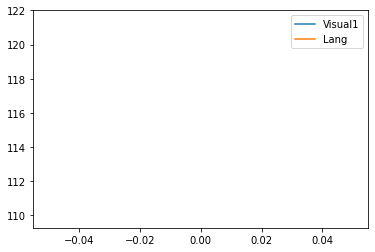

In [159]:
# Pick a random region to compare - V1
region1 = subject_rois[0]#
region2 = subject_rois[1][0]
plt.plot(region1,label='Visual1') 
plt.plot(region2,label='Lang') 
plt.legend()
# Why do they overlap so much?
np.shape(subject_rois[0])

In [ ]:
# Getting data - selective_average function?
https://neurostars.org/t/updates-to-hcp-data-loader-including-visualization/15525
https://neurostars.org/t/some-helper-functions-for-loading-hcp/15241


# Granger causality

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
# Checks if the TS in column 2 Granger-causes the TS in column 1
def GC_two_regions(all_ts, region_name1,region_name2):
  idx1 = regionsdf.index[regionsdf['name'].str.contains(region_name1)].tolist() # get indices
  region1 = np.mean(all_ts[idx1,],axis = 0)
  idx2 = regionsdf.index[regionsdf['name'].str.contains(region_name2)].tolist() # get indices
  region2 = np.mean(all_ts[idx2,],axis = 0)
  regions_combined = np.vstack((region1,region2)).T 
  grangercausalitytests(regions_combined,1,verbose=True)
GC_two_regions(all_ts, 'STS','TPOJ') # For the entire experiment


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5137  , p=0.0614  , df_denom=544, df_num=1
ssr based chi2 test:   chi2=3.5331  , p=0.0602  , df=1
likelihood ratio test: chi2=3.5217  , p=0.0606  , df=1
parameter F test:         F=3.5137  , p=0.0614  , df_denom=544, df_num=1


In [ ]:
# Extract condition runs
subj_id = 0
task = 'SOCIAL'
all_ts_run0 = load_timeseries(subj_id, 'SOCIAL', runs=0) # Run 0
# Mentalizing
mental_frames = condition_frames(load_evs(subj_id, task, 'mental'))
mental_ts = all_ts_run0[:,mental_frames[0]]
# Random
random_frames = condition_frames(load_evs(subj_id, task, 'rnd'))
random_ts = all_ts_run0[:,random_frames[0]]
# Run GC
GC_two_regions(mental_ts, 'STS','TPOJ')
GC_two_regions(random_ts, 'STS','TPOJ')


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6842  , p=0.4114  , df_denom=60, df_num=1
ssr based chi2 test:   chi2=0.7184  , p=0.3967  , df=1
likelihood ratio test: chi2=0.7144  , p=0.3980  , df=1
parameter F test:         F=0.6842  , p=0.4114  , df_denom=60, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0060  , p=0.9384  , df_denom=92, df_num=1
ssr based chi2 test:   chi2=0.0062  , p=0.9372  , df=1
likelihood ratio test: chi2=0.0062  , p=0.9372  , df=1
parameter F test:         F=0.0060  , p=0.9384  , df_denom=92, df_num=1


## GC in nipype


In [ ]:
!pip install nitime
import nitime
import nitime.analysis as nta
import nitime.timeseries as ts
import nitime.utils as tsu

In [ ]:
TR = 0.72 # time res
f_ub = 0.15
f_lb = 0.02 # physiologically relevant freqs

In [ ]:
# stack regions
idx1 = regionsdf.index[regionsdf['name'].str.contains('STS')].tolist() # get indices
region1 = np.mean(all_ts[idx1,],axis = 0)
idx2 = regionsdf.index[regionsdf['name'].str.contains('TPOJ')].tolist() # get indices
region2 = np.mean(all_ts[idx2,],axis = 0)
#idx3 = regionsdf.index[regionsdf['name'].str.contains('V1')].tolist() # get indices
#region3 = np.mean(all_ts[idx2,],axis = 0)
regions_combined = np.vstack((region1,region2)) #region3))
np.shape(regions_combined)

(2, 274)

In [ ]:
pdata = tsu.percent_change(regions_combined) #convert to percentage change ??
time_series = ts.TimeSeries(pdata, sampling_interval=TR)

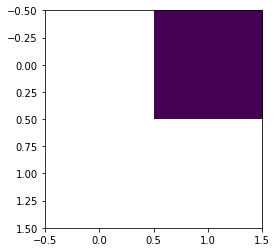

In [ ]:
G = nta.GrangerAnalyzer(time_series, order=1)
freq_idx_G = np.where((G.frequencies > f_lb) * (G.frequencies < f_ub))[0] # find where relevant frequencies are
g_caus = np.mean(G.causality_xy[:, :, freq_idx_G] - G.causality_yx[:, :, freq_idx_G],-1) # diff between two directions
plt.imshow(g_caus)

# ANOVA